<a href="https://colab.research.google.com/github/hemanshupatil-Statistician/Cotton-Leaf-Disease-Detection/blob/main/cotton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set Seed reproducibility.
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [3]:
import os
import json
import cv2
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras import Model, Sequential

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle .json to kaggle .json


{'kaggle .json': b'{"username":"hemanshupatil2002","key":"e2359d18573f8cffa0d8a66236adf103"}'}

In [ ]:
!mkdir ~/.kaggle

In [4]:
# Add a dummy kaggle.json file if it doesn't exist
if not os.path.exists('kaggle.json'):
  with open('kaggle.json', 'w') as f:
    json.dump({}, f)

Kaggle_credentials = json.load(open('kaggle.json'))
os.environ['KAGGLE_USERNAME'] = Kaggle_credentials.get('username', '')
os.environ['KAGGLE_KEY'] = Kaggle_credentials.get('key', '')

In [5]:
!kaggle datasets download -d seroshkarim/cotton-leaf-disease-dataset -p /content/ --unzip

Dataset URL: https://www.kaggle.com/datasets/seroshkarim/cotton-leaf-disease-dataset
License(s): unknown
 71% 128M/181M [00:00<00:00, 1.34GB/s]
100% 181M/181M [00:00<00:00, 1.09GB/s]


In [6]:
!unzip /content/cotton-leaf-disease-dataset.zip -d /content/cotton leaf disease

unzip:  cannot find or open /content/cotton-leaf-disease-dataset.zip, /content/cotton-leaf-disease-dataset.zip.zip or /content/cotton-leaf-disease-dataset.zip.ZIP.


In [7]:
import os

# Path to the dataset
data_dir = '/content/cotton'

# Count the number of images in each class
classes = ['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    print(f'Checking path: {cls_path}')
    if os.path.exists(cls_path):
        print(f'Number of images in {cls}:', len(os.listdir(cls_path)))
    else:
        print(f'Path does not exist: {cls_path}')

Checking path: /content/cotton/bacterial_blight
Number of images in bacterial_blight: 448
Checking path: /content/cotton/curl_virus
Number of images in curl_virus: 418
Checking path: /content/cotton/fussarium_wilt
Number of images in fussarium_wilt: 419
Checking path: /content/cotton/healthy
Number of images in healthy: 426


In [8]:
from PIL import Image
import numpy as np

# Check image dimensions
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        img = Image.open(img_path)
        print(f'{img_file}: {img.size}')  # Prints the size of each image
        break  # Remove break if you want to check all images


bact72.jpg: (225, 300)
curl242.jpg: (595, 597)
done6.jpg: (228, 197)
h248.jpg: (567, 608)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions and batch size
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

# Data generator with validation split
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

# Training data generator (80% of the data)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation data generator (20% of the data)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 1369 images belonging to 4 classes.
Found 340 images belonging to 4 classes.


In [10]:
print(train_generator.class_indices)

{'bacterial_blight': 0, 'curl_virus': 1, 'fussarium_wilt': 2, 'healthy': 3}


In [11]:
# Example CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes for classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,868 (40.58 MB)

 Trainable params: 10,636,868 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Training the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 544ms/step - accuracy: 0.3672 - loss: 2.3884 - val_accuracy: 0.6324 - val_loss: 0.8547
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 305ms/step - accuracy: 0.6400 - loss: 0.8546 - val_accuracy: 0.7824 - val_loss: 0.7396
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 305ms/step - accuracy: 0.7849 - loss: 0.5613 - val_accuracy: 0.8088 - val_loss: 0.5677
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 305ms/step - accuracy: 0.8515 - loss: 0.4095 - val_accuracy: 0.7971 - val_loss: 0.5143
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step - accuracy: 0.8976 - loss: 0.2856 - val_accuracy: 0.7588 - val_loss: 0.7723
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - accuracy: 0.8940 - loss: 0.3319 - val_accuracy: 0.8353 - val_loss: 0.4733
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 308ms/step - accuracy: 0.9124 - loss: 0.2493 - val_accuracy: 0.8206 - val_loss: 0.5248
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 304ms/step - accuracy: 0.9488 - loss: 0.1860 - val_accu

In [13]:
# Save the trained model
model.save('CNNmodel.keras')


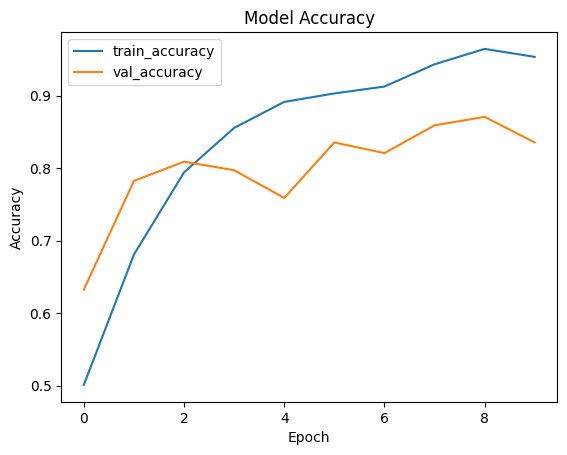

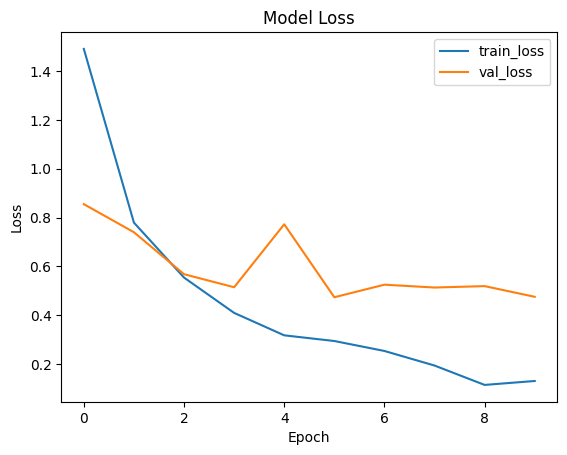

In [14]:
# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('CNNmodel.keras')

# Path to new image for testing
img_path = '/content/cotton/bacterial_blight/P1010086jpg.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Class names mapping (adjust to your classes)
class_labels = {0: 'Bacterial Blight', 1: 'Curl Virus', 2: 'Fussarium Wilt', 3: 'Healthy'}
print(f"The predicted class is: {class_labels[predicted_class]}")


[ ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
The predicted class is: Bacterial Blight
